# アンサンブル学習

In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

# 色々なメソッドが引き継げる
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote='classlabel', weights=None):
        """
        多数決アンサンブル分類器

        パラメータ
        ----------
        classifiers : array-like, shape = [n_classifiers]
            アンサンブルのさまざまな分類器
        vote : str, {'classlabel', 'probability'}
            'classlabel'（デフォルト）の場合、クラスラベルの予測はクラスラベルのargmaxに基づき、
            'probability'の場合はクラスの所属確率のargmaxに基づく
        weights : array-like, shape = [n_classifiers], optional
            int または float 型のリストが提供された場合は重みとして重要度を使い、
            None（デフォルト）の場合は均一な重みを使う
        """
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """
        分類器を適合させる

        パラメータ
        ----------
        X : array-like, shape = [n_examples, n_features]
            訓練データ
        y : array-like, shape = [n_examples]
            クラスラベルのベクトル

        戻り値
        -------
        self : object
        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"vote must be 'probability' or 'classlabel'; got (vote={self.vote})")

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError(f"Number of classifiers and weights must be equal; "
                             f"got {len(self.weights)} weights, "
                             f"{len(self.classifiers)} classifiers")

        # LabelEncoder を使ってクラスラベルが 0 始まりになるようにエンコード
        self.labelenc_ = LabelEncoder()
        self.labelenc_.fit(y)
        self.classes_ = self.labelenc_.classes_
        self.classifiers_ = []

        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.labelenc_.transform(y))
            self.classifiers_.append(fitted_clf)

        return self

    def predict(self, X):
        """
        Xのクラスラベルを予測する

        パラメータ
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            テストデータ

        戻り値
        -------
        maj_vote : array-like, shape = [n_examples]
            予測されたクラスラベル
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel'
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(
                lambda x: np.argmax(np.bincount(x, weights=self.weights)),
                axis=1,
                arr=predictions
            )
        maj_vote = self.labelenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """
        Xのクラス確率を予測する

        パラメータ
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]

        戻り値
        -------
        avg_proba : array-like, shape = [n_examples, n_classes]
            平均確率
        """
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """
        GridSearchの実行時に分類器のパラメータ名を取得

        パラメータ
        ----------
        deep : bool
            Trueの場合は分類器のすべてのパラメータを含める

        戻り値
        -------
        out : dict
            パラメータの名前と値のディクショナリ
        """
        if not deep:
            return super().get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out[f'{name}__{key}'] = value
            return out


In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

iris = datasets.load_iris()
X, y = iris.data[50:, [1,2]], iris.target[50:]  # 最後の50個のサンプルを使用
le = LabelEncoder()
y = le.fit_transform(y)  # クラスラベルをエンコード

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

clf1 = LogisticRegression(penalty='l2', C=0.001, solver='lbfgs', random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])
clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print(f'{label}: {scores.mean():.3f} (+/- {scores.std():.3f})')

10-fold cross validation:

Logistic regression: 0.917 (+/- 0.154)
Decision tree: 0.867 (+/- 0.183)
KNN: 0.850 (+/- 0.133)


In [4]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
mv_clf.fit(X_train, y_train)
print('\nMajority vote classifier:\n')
print(f'Accuracy: {mv_clf.score(X_test, y_test):.3f}')
print(f'Predicted class labels: {mv_clf.predict(X_test)}')
print(f'Predicted class probabilities:\n{mv_clf.predict_proba(X_test)}')
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='accuracy') # roc_aucだとなぜかうまくいかない
    print(f'{label}: {scores.mean():.3f} (+/- {scores.std():.3f})')


Majority vote classifier:

Accuracy: 0.900
Predicted class labels: [0 0 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 0 1 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0
 1 1 0 1 0 0 1 0 0 1 0 0 0]
Predicted class probabilities:
[[0.80858947 0.19141053]
 [0.8079866  0.1920134 ]
 [0.80742132 0.19257868]
 [0.81176643 0.18823357]
 [0.81195787 0.18804213]
 [0.17701335 0.82298665]
 [0.17670558 0.82329442]
 [0.17845724 0.82154276]
 [0.1796253  0.8203747 ]
 [0.81076209 0.18923791]
 [0.80838852 0.19161148]
 [0.17808359 0.82191641]
 [0.80916413 0.19083587]
 [0.17767238 0.82232762]
 [0.18043853 0.81956147]
 [0.17703214 0.82296786]
 [0.1796629  0.8203371 ]
 [0.47640541 0.52359459]
 [0.17941495 0.82058505]
 [0.81213051 0.18786949]
 [0.17905065 0.82094935]
 [0.80820636 0.19179364]
 [0.81020637 0.18979363]
 [0.80722036 0.19277964]
 [0.17764419 0.82235581]
 [0.80974814 0.19025186]
 [0.51300563 0.48699437]
 [0.80938386 0.19061614]
 [0.80722976 0.19277024]
 [0.17785449 0.82214551]
 [0.17906005 0.82093995]
 [0.80778564 0.19221436

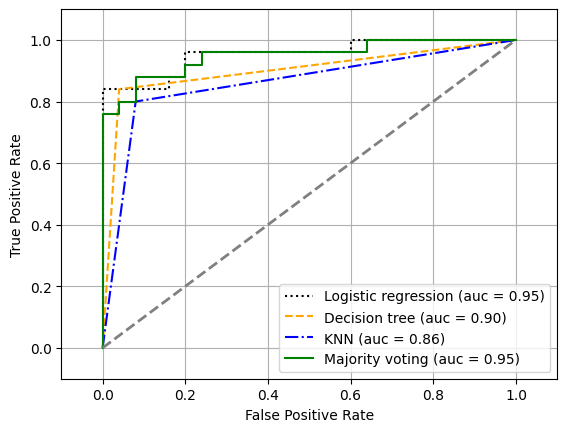

In [5]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# plt.tight_layout()
# plt.savefig('./figures/roc.png', dpi=300)
plt.show()

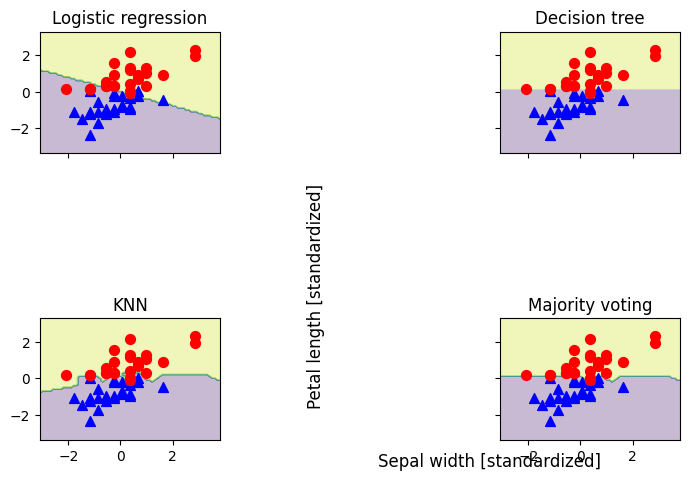

In [ ]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product

all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='red', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -4.5, 
         s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-10.5, 4.5, 
         s='Petal length [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)

plt.tight_layout()
# plt.savefig('./figures/voting_panel', bbox_inches='tight', dpi=300)
plt.show()

In [9]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__transform_input': None,
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf

In [14]:
from sklearn.model_selection import GridSearchCV

params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='accuracy',)
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print(f"Grid {r}: {grid.cv_results_['params'][r]}, "
          f"Mean accuracy: {grid.cv_results_['mean_test_score'][r]:.3f} "
          f"(std: {grid.cv_results_['std_test_score'][r]:.3f})")

Grid 0: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}, Mean accuracy: 0.920 (std: 0.133)
Grid 1: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}, Mean accuracy: 0.940 (std: 0.092)
Grid 2: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}, Mean accuracy: 0.900 (std: 0.184)
Grid 3: {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}, Mean accuracy: 0.920 (std: 0.133)
Grid 4: {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}, Mean accuracy: 0.940 (std: 0.092)
Grid 5: {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}, Mean accuracy: 0.900 (std: 0.184)
